# Imports

In [1]:
# Data
from data                   import commodities, nutrients
# Importing libraries
from random                 import shuffle, choice, sample, random, uniform
from copy                   import deepcopy
from operator               import attrgetter
import matplotlib.pyplot    as plt
import numpy                as np
import pandas               as pd
# Importing classes and functions
from individual             import Individual                                       #
from population             import Population                                       #
from selection              import roulette, ranked, tournament                     #
from variation              import crossover, mutation                              #
from fitness                import get_fitness                                      #

# Functions

In [2]:
def evaluation(population_size, evolve_parameters, iterations=30):
    history = {}
    items_combined = []
    products = []
    populations = []
    for i in range(iterations):
        # Monkey Patching
        Individual.get_fitness = get_fitness
        # create initial population
        pop = Population(size=population_size, optim="min", sol_size=len(commodities), valid_set=list(range(2)), replacement=True)
        # evolve
        pop.evolve(
            select = evolve_parameters['select'],
            tournament_k = evolve_parameters['tournament_k'],
            gens = evolve_parameters['gens'], 
            mut_prob = evolve_parameters['mut_prob'],
            mutate = evolve_parameters['mutate'],
            mut_type = evolve_parameters['mut_type'],
            mut_cycles = evolve_parameters['mut_cycles'],
            bit_flips = evolve_parameters['bit_flips'],
            xo_prob = evolve_parameters['xo_prob'],
            crossover = evolve_parameters['crossover'],
            xo_type = evolve_parameters['xo_type'],
            elitism = evolve_parameters['elitism']
        )
        
        history[i] = pop.history_fitness
        items_combined += pop.history_products
        products.append(pop.history_products)
        populations.append(pop)

    product_count = {i:items_combined.count(i) for i in set(items_combined)}

    min_individual = np.argmin(np.array(list(history.values()))[:,-1])
    table = {}
    for i in products[min_individual]:
        table[i] = commodities[i][0]
    table['SUM'] = round(sum(table.values()),4)

    best_of_individuals = (np.array(list(history.values()))[:,-1])
    print(f'Average - Fitness: {round(np.mean(best_of_individuals),4)} USD$')
    print(f'Standard Deviation - Fitness: {round(np.std(best_of_individuals),4)} USD$')
    
    return history, product_count, table, populations[min_individual]

def plot_results(results, product_count, table, nutri, nutrients=nutrients):
    fig = plt.figure(figsize=(15, 15))
    gs = fig.add_gridspec(nrows=2, ncols=2)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    # ax3 = fig.add_subplot(gs[1, :])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])

    # fitness history lineplot
    for i in results.keys():
        ax1.plot(list(results.values())[i-1], label=f'Run {i}')
    ax1.plot(np.mean(list(results.values()), axis=0), color='black', label='Mean', linestyle='--', linewidth=4)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_title('Fitness History')
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Fitness ($)')
    ax1.legend(ncol=2, fontsize=8, loc='upper right')

    # product count barplot
    product_count_sorted = {k: v for k, v in sorted(product_count.items(), key=lambda item: item[1])[-10:]}
    prods = list(product_count_sorted.keys())
    vals = list(product_count_sorted.values())
    ax2.barh(prods, vals)
    for i, v in enumerate(vals):
        if len(prods[i]) <= v*4:
            # label fits inside bar
            ax2.text(v / 2, i, prods[i], ha='center', va='center')
        else:
            # label doesn't fit inside bar, place at edge
            ax2.text(v + 0.5, i, prods[i], ha='left', va='center')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.set_yticks([])
    ax2.set_yticklabels([])
    ax2.set_title('Most Common Optimal Products (Top 10)')
    ax2.set_xlabel('Count')

    # best solution table
    df = pd.DataFrame(table, index=['Price ($)']).T.reset_index().rename(columns={'index':'Product'})
    cols = [["w","w"] for i in range(len(df))]
    cols[-1] = ["#C5C7C5","#C5C7C5"]
    table = ax3.table(cellText=df.values,colLabels=df.columns,rowLabels=df.index,loc='center',cellLoc='center', cellColours=cols)
    table.auto_set_font_size(False)
    table.set_fontsize(7)
    # table.scale(1, 1.5)
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    ax3.set_title('Best Solution')

    # nutrients of best solution
    generations = list(range(len(nutri.history_calories)))
    ax4.plot(generations, nutri.history_calories, label='Calories (kcal)', c='red')
    ax4.axhline(y = nutrients['Calories (kcal)'], linestyle = ':', c='red')
    ax4.plot(generations, nutri.history_protein, label='Protein (g)', c='green')
    ax4.axhline(y = nutrients['Protein (g)'], linestyle = ':', c='green')
    ax4.plot(generations, nutri.history_carbohydrates, label='Carbohydrates (g)', c='blue')
    ax4.axhline(y = nutrients['Carbohydrates (g)'], linestyle = ':', c='blue')
    ax4.plot(generations, nutri.history_fat, label='Total Fat (g)', c='orange')
    ax4.axhline(y = nutrients['Total Fat (g)'], linestyle = ':', c='orange')
    ax4.plot(generations, nutri.history_sodium, label='Sodium (mg)', c='magenta')
    ax4.axhline(y = nutrients['Sodium (mg)'], linestyle = ':', c='magenta')
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    ax4.set_yscale("log")
    ax4.set_xlabel("Generations")
    ax4.set_ylabel("Nutrition Values")
    ax4.set_title("Nutrition Curves")
    ax4.legend(loc ="upper right", fontsize="8")

    plt.show()

# 1st Run

|Parameter                 | Value             |
|--------------------------|-------------------|
|Generations per Iterarion:| 30                |
|Population Size:          | 500               |               
|Selection:                | Roulette          |
|Mutation:                 | Single-Bit-Flip   |
|Crossover:                | One-Point         |
|Elitism:                  | True              |

In [3]:
evolve_parameters = {
    "select": roulette,
    "tournament_k": None,
    "gens": 30,
    "mut_prob": 0.2,
    "mutate": mutation,
    "mut_type": "single_bit_flip",
    "mut_cycles": None,
    "bit_flips": None,
    "xo_prob": 0.9,
    "crossover": crossover,
    "xo_type": "one-point",
    "elitism": True
    }

results, product_count, table, nutri = evaluation(population_size=500, evolve_parameters=evolve_parameters)

Average - Fitness: 105.6463 USD$
Standard Deviation - Fitness: 7.0191 USD$


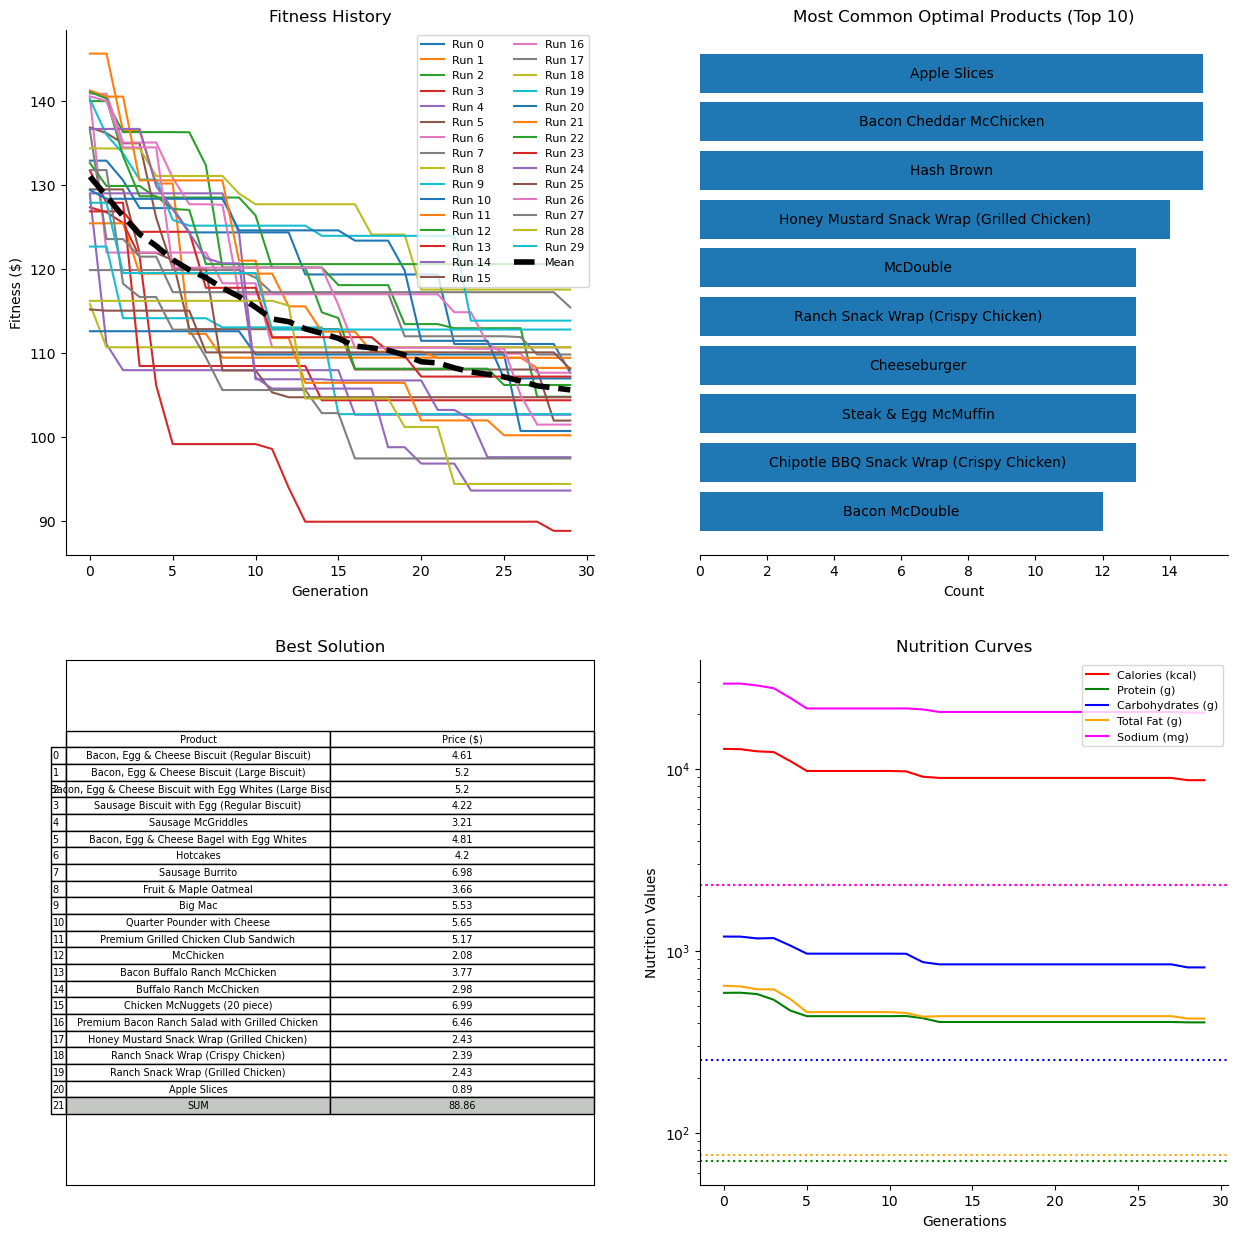

In [4]:
plot_results(results, product_count, table, nutri)

**Conclusion**

|Metric      |Score        |
|------------|-----        |
|Avg. Fitness|fill in value|
|Std. Fitness|fill in value|

- Algorithm decreases slowly
- Volatile curves
- No convergence reached

---

# 2nd Run

|Parameter                 | Value             |
|--------------------------|-------------------|
|Generations per Iterarion:| 100               |
|Population Size:          | 500               |               
|Selection:                | **Ranked**        |
|Mutation:                 | Single-Bit-Flip   |
|Crossover:                | One-Point         |
|Elitism:                  | True              |

Changing Selection from **Roulette** to **Ranked**

In [5]:
evolve_parameters = {
    "select": ranked,
    "tournament_k": None,
    "gens": 30,
    "mut_prob": 0.2,
    "mutate": mutation,
    "mut_type": "single_bit_flip",
    "mut_cycles": None,
    "bit_flips": None,
    "xo_prob": 0.9,
    "crossover": crossover,
    "xo_type": "one-point",
    "elitism": True
    }

results, product_count, table, nutri = evaluation(population_size=500, evolve_parameters=evolve_parameters)

Average - Fitness: 16.404 USD$
Standard Deviation - Fitness: 1.1836 USD$


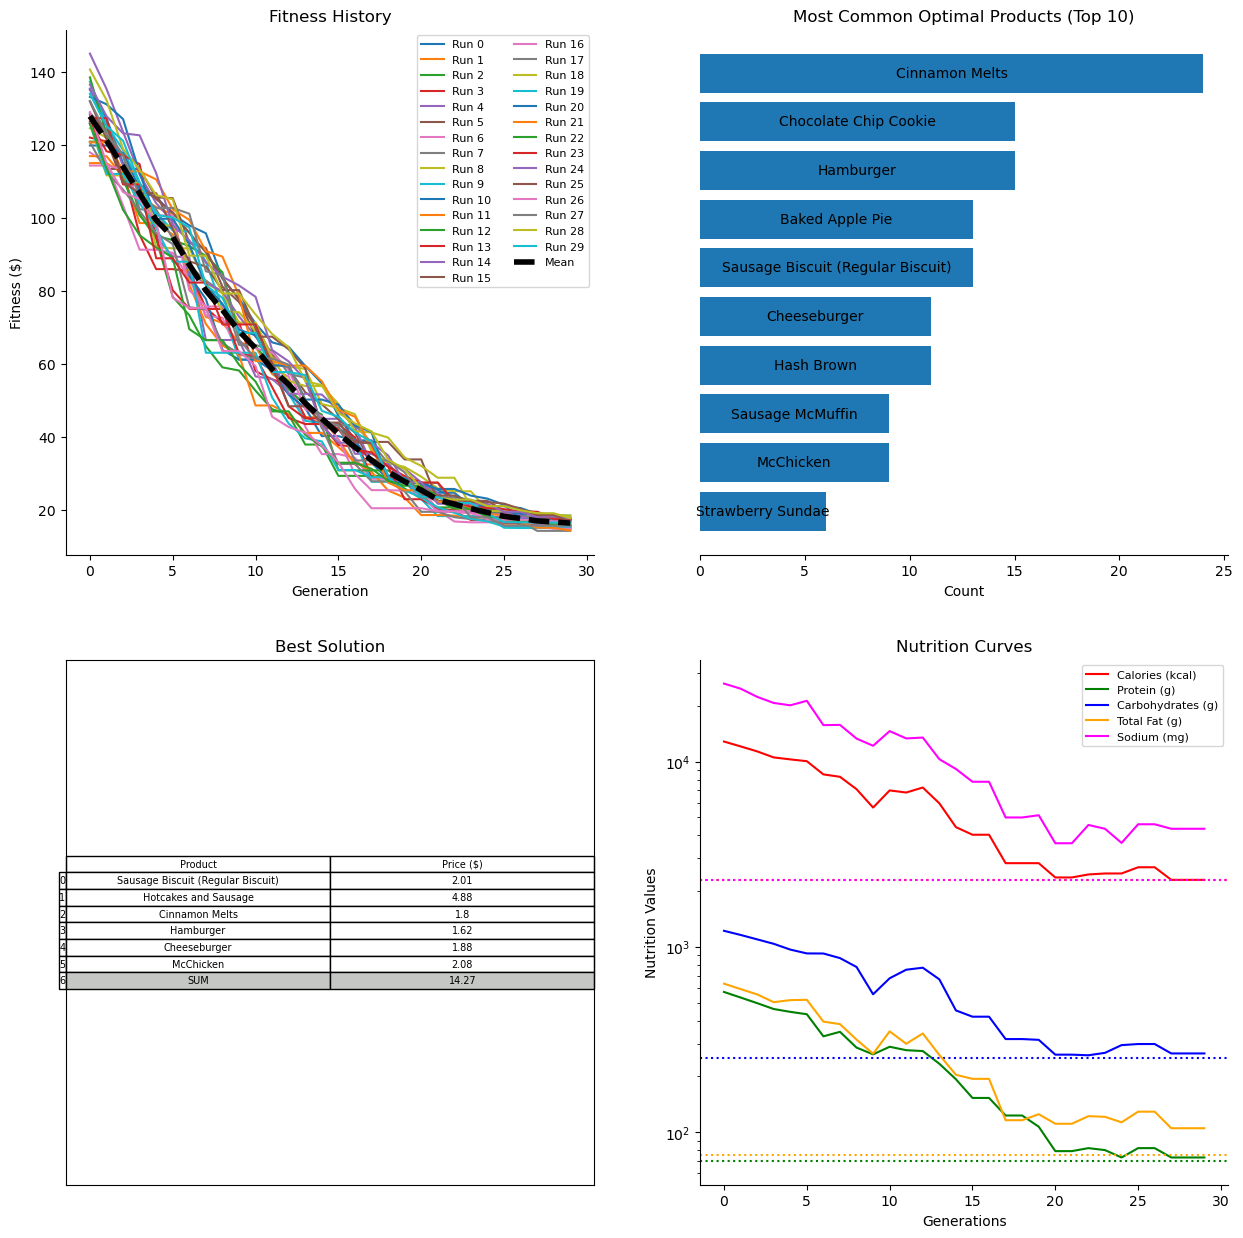

In [6]:
plot_results(results, product_count, table, nutri)

**Conclusion**

|Metric      |Score        |
|------------|-----        |
|Avg. Fitness|fill in value|
|Std. Fitness|fill in value|

Changing the selection algorithm helps speeding up the minimization

---

# 3rd Run

|Parameter                 | Value             |
|--------------------------|-------------------|
|Generations per Iterarion:| 100               |
|Population Size:          | 500               |               
|Selection:                | **Tournament**    |
|Mutation:                 | Single-Bit-Flip   |
|Crossover:                | One-Point         |
|Elitism:                  | True              |

Changing Selection from **Ranked** to **Tournament** (k = 5)

In [7]:
evolve_parameters = {
    "select": tournament,
    "tournament_k": 5,
    "gens": 30,
    "mut_prob": 0.2,
    "mutate": mutation,
    "mut_type": "single_bit_flip",
    "mut_cycles": None,
    "bit_flips": None,
    "xo_prob": 0.9,
    "crossover": crossover,
    "xo_type": "one-point",
    "elitism": True
    }

results, product_count, table, nutri = evaluation(population_size=500, evolve_parameters=evolve_parameters)

Average - Fitness: 14.6803 USD$
Standard Deviation - Fitness: 1.1592 USD$


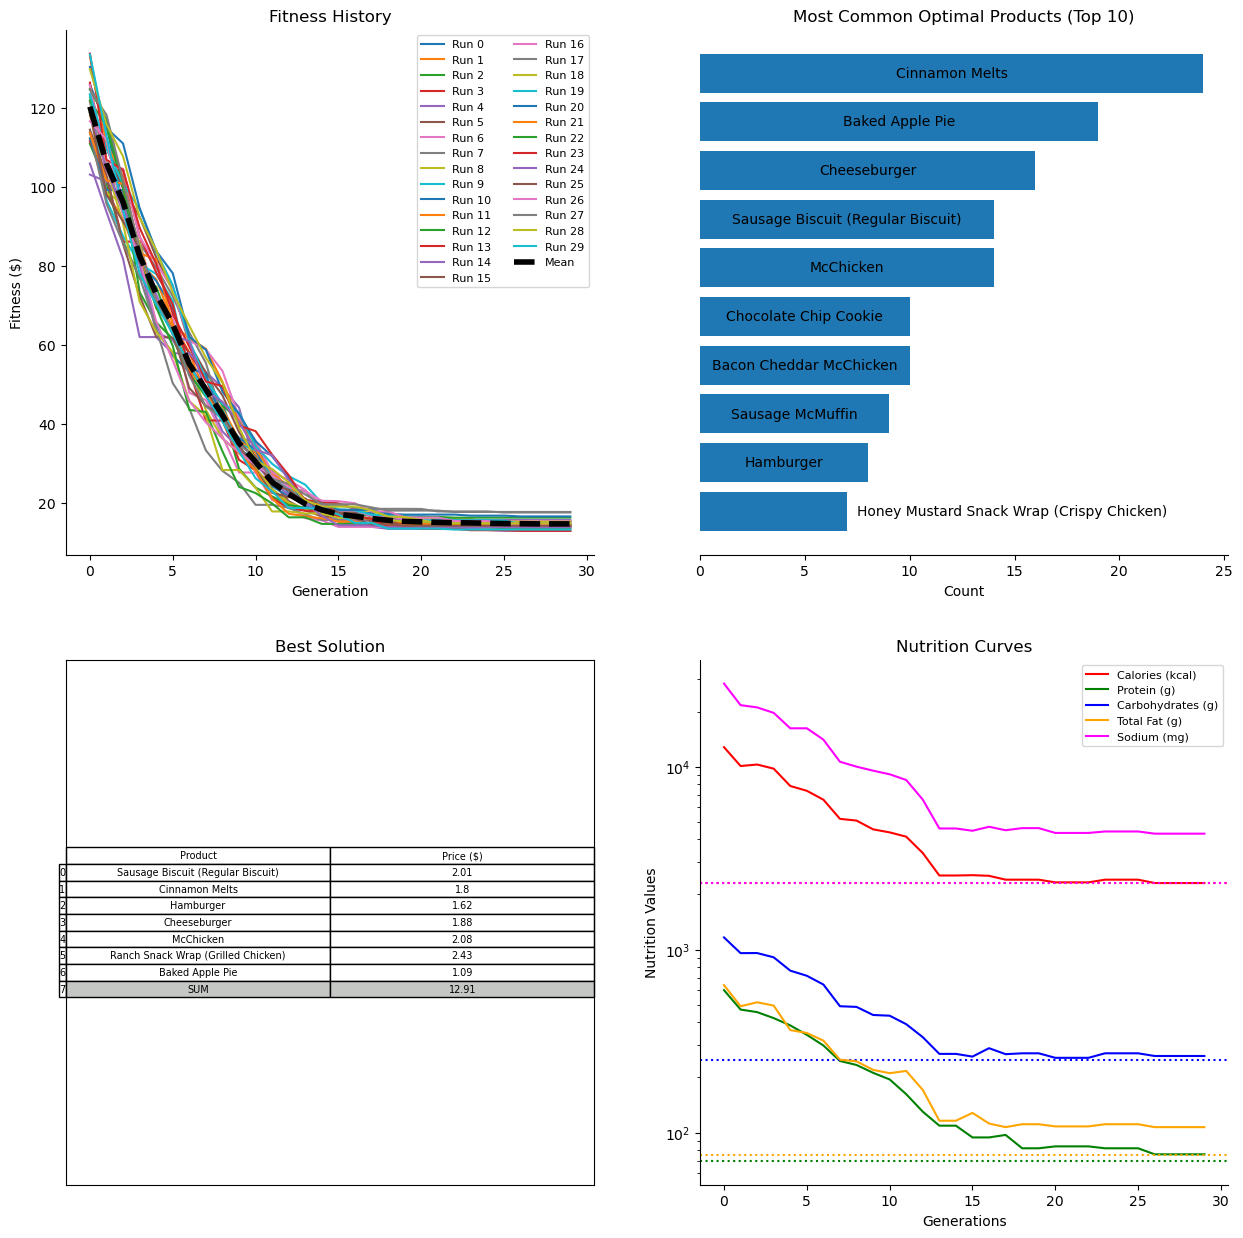

In [8]:
plot_results(results, product_count, table, nutri)

**Conclusion**

|Metric      |Score        |
|------------|-----        |
|Avg. Fitness|fill in value|
|Std. Fitness|fill in value|

By only manipulating the **Selection Parameter** (ceteris paribus) **Tournament** seems to minimizes the fitness function the fastest

---

# 4th Run

|Parameter                 | Value             |
|--------------------------|-------------------|
|Generations per Iterarion:| 100               |
|Population Size:          | 500               |
|Selection:                | Tournament        |
|Mutation:                 | Single-Bit-Flip   |
|Crossover:                | **Five-Point**    |
|Elitism:                  | True              |

Changing Crossover from **One-Point** to **Five-Point**

In [9]:
evolve_parameters = {
    "select": tournament,
    "tournament_k": 5,
    "gens": 30,
    "mut_prob": 0.2,
    "mutate": mutation,
    "mut_type": "single_bit_flip",
    "mut_cycles": None,
    "bit_flips": None,
    "xo_prob": 0.9,
    "crossover": crossover,
    "xo_type": "five-point",
    "elitism": True
    }

results, product_count, table, nutri = evaluation(population_size=500, evolve_parameters=evolve_parameters)

Average - Fitness: 12.7193 USD$
Standard Deviation - Fitness: 0.4174 USD$


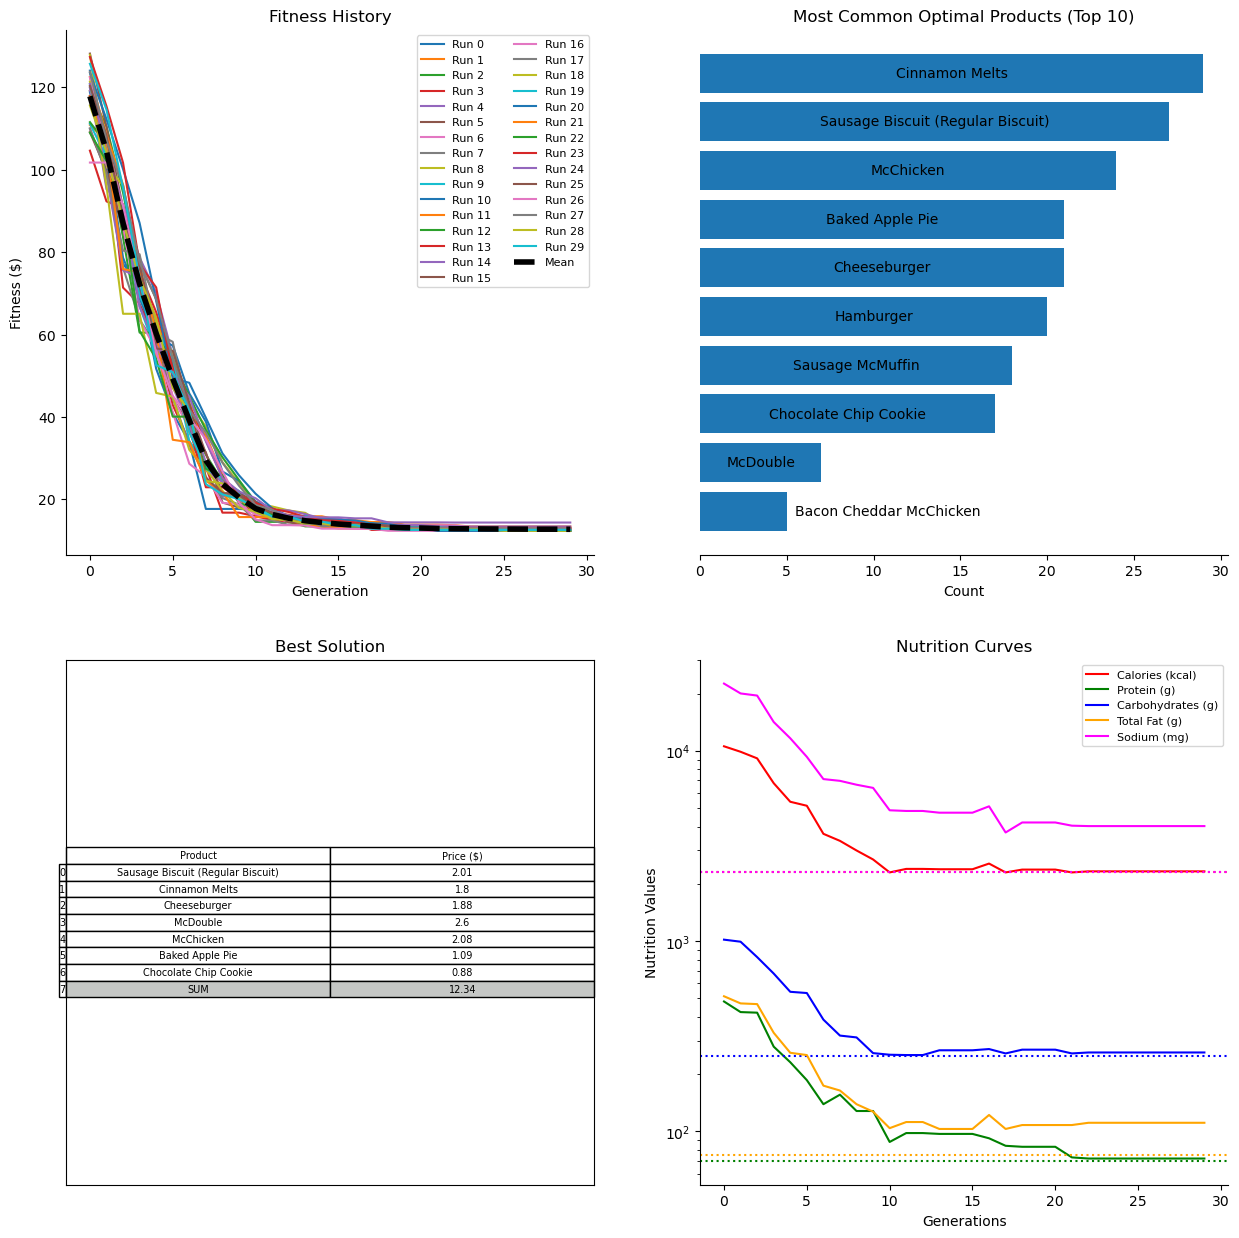

In [10]:
plot_results(results, product_count, table, nutri)

**Conclusion**

|Metric      |Score        |
|------------|-----        |
|Avg. Fitness|fill in value|
|Std. Fitness|fill in value|

---

# 5th Run

|Parameter                 | Value             |
|--------------------------|-------------------|
|Generations per Iterarion:| 100               |
|Population Size:          | 500               |
|Selection:                | Tournament        |
|Mutation:                 | Single-Bit-Flip   |
|Crossover:                | **Ten-Point**     |
|Elitism:                  | True              |

Changing Crossover from **Five-Point** to **Ten-Point**

In [11]:
evolve_parameters = {
    "select": tournament,
    "tournament_k": 5,
    "gens": 30,
    "mut_prob": 0.2,
    "mutate": mutation,
    "mut_type": "single_bit_flip",
    "mut_cycles": None,
    "bit_flips": None,
    "xo_prob": 0.9,
    "crossover": crossover,
    "xo_type": "ten-point",
    "elitism": True
    }

results, product_count, table, nutri = evaluation(population_size=500, evolve_parameters=evolve_parameters)

Average - Fitness: 12.554 USD$
Standard Deviation - Fitness: 0.3046 USD$


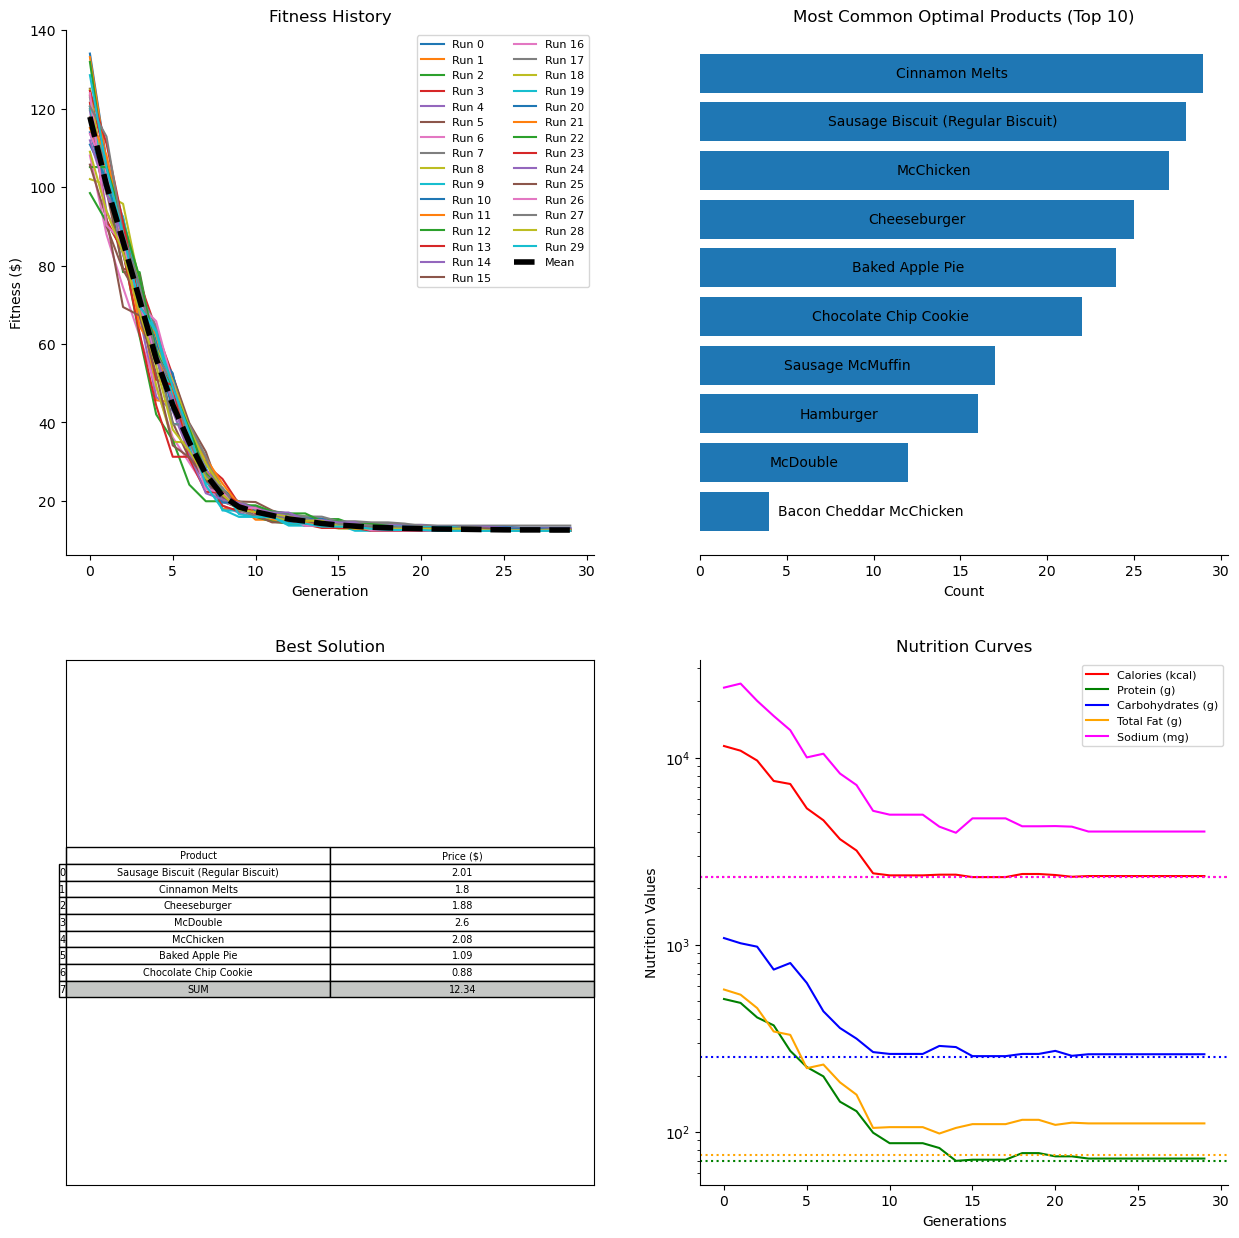

In [12]:
plot_results(results, product_count, table, nutri)

**Conclusion**

|Metric      |Score        |
|------------|-----        |
|Avg. Fitness|fill in value|
|Std. Fitness|fill in value|

---

# 6th Run

|Parameter                 | Value             |
|--------------------------|-------------------|
|Generations per Iterarion:| 100               |
|Population Size:          | 500               |
|Selection:                | Tournament        |
|Mutation:                 | Single-Bit-Flip   |
|Crossover:                | **Uniform**       |
|Elitism:                  | True              |

Changing Crossover from **Ten-Point** to **Uniform**

In [13]:
evolve_parameters = {
    "select": tournament,
    "tournament_k": 5,
    "gens": 30,
    "mut_prob": 0.2,
    "mutate": mutation,
    "mut_type": "single_bit_flip",
    "mut_cycles": None,
    "bit_flips": None,
    "xo_prob": 0.9,
    "crossover": crossover,
    "xo_type": "uniform",
    "elitism": True
    }

results, product_count, table, nutri = evaluation(population_size=500, evolve_parameters=evolve_parameters)

Average - Fitness: 12.3997 USD$
Standard Deviation - Fitness: 0.1149 USD$


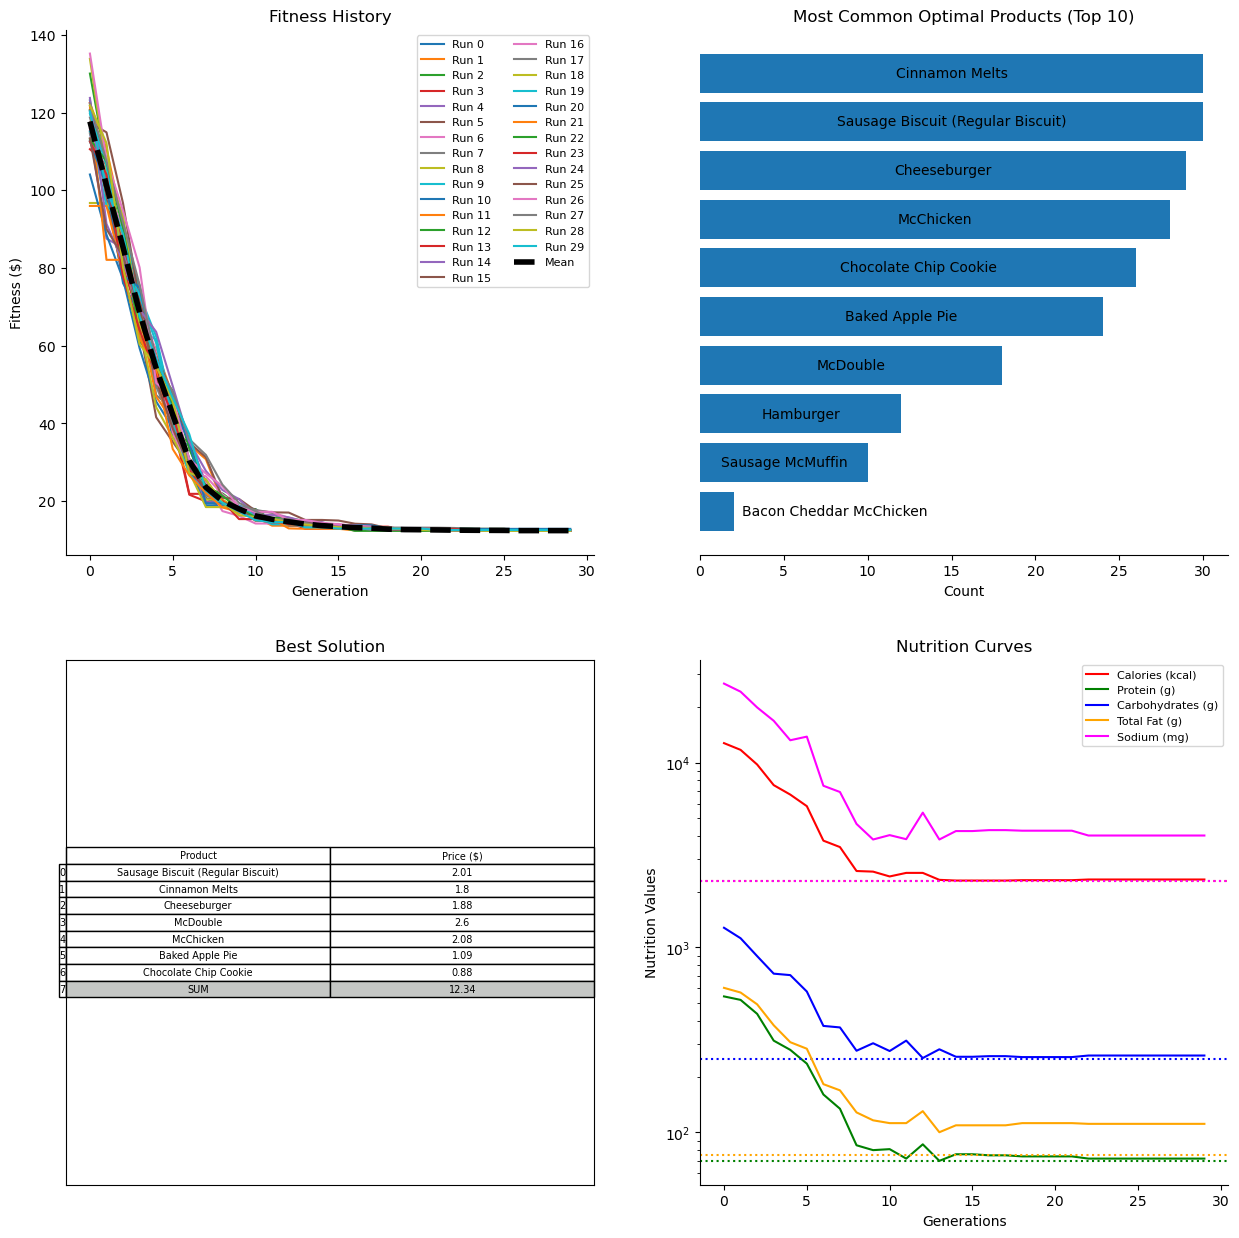

In [14]:
plot_results(results, product_count, table, nutri)

**Conclusion**

|Metric      |Score        |
|------------|-----        |
|Avg. Fitness|fill in value|
|Std. Fitness|fill in value|

---

# 7th Run

|Parameter                 | Value                           |
|--------------------------|---------------------------------|
|Generations per Iterarion:| 100                             |
|Population Size:          | 500                             |
|Selection:                | Tournament                      |
|Mutation:                 | **Complete_Bit_Flip**           |
|Crossover:                | Ten-Point                       |
|Elitism:                  | True                            |

Changing Mutation from **Single-Bit-Flip** to **Complete_Bit_Flip**

In [15]:
evolve_parameters = {
    "select": tournament,
    "tournament_k": 5,
    "gens": 30,
    "mut_prob": 0.2,
    "mutate": mutation,
    "mut_type": "complete_bit_flip",
    "mut_cycles": None,
    "bit_flips": None,
    "xo_prob": 0.9,
    "crossover": crossover,
    "xo_type": "ten-point",
    "elitism": True
    }

results, product_count, table, nutri = evaluation(population_size=500, evolve_parameters=evolve_parameters)

Average - Fitness: 12.7477 USD$
Standard Deviation - Fitness: 0.4975 USD$


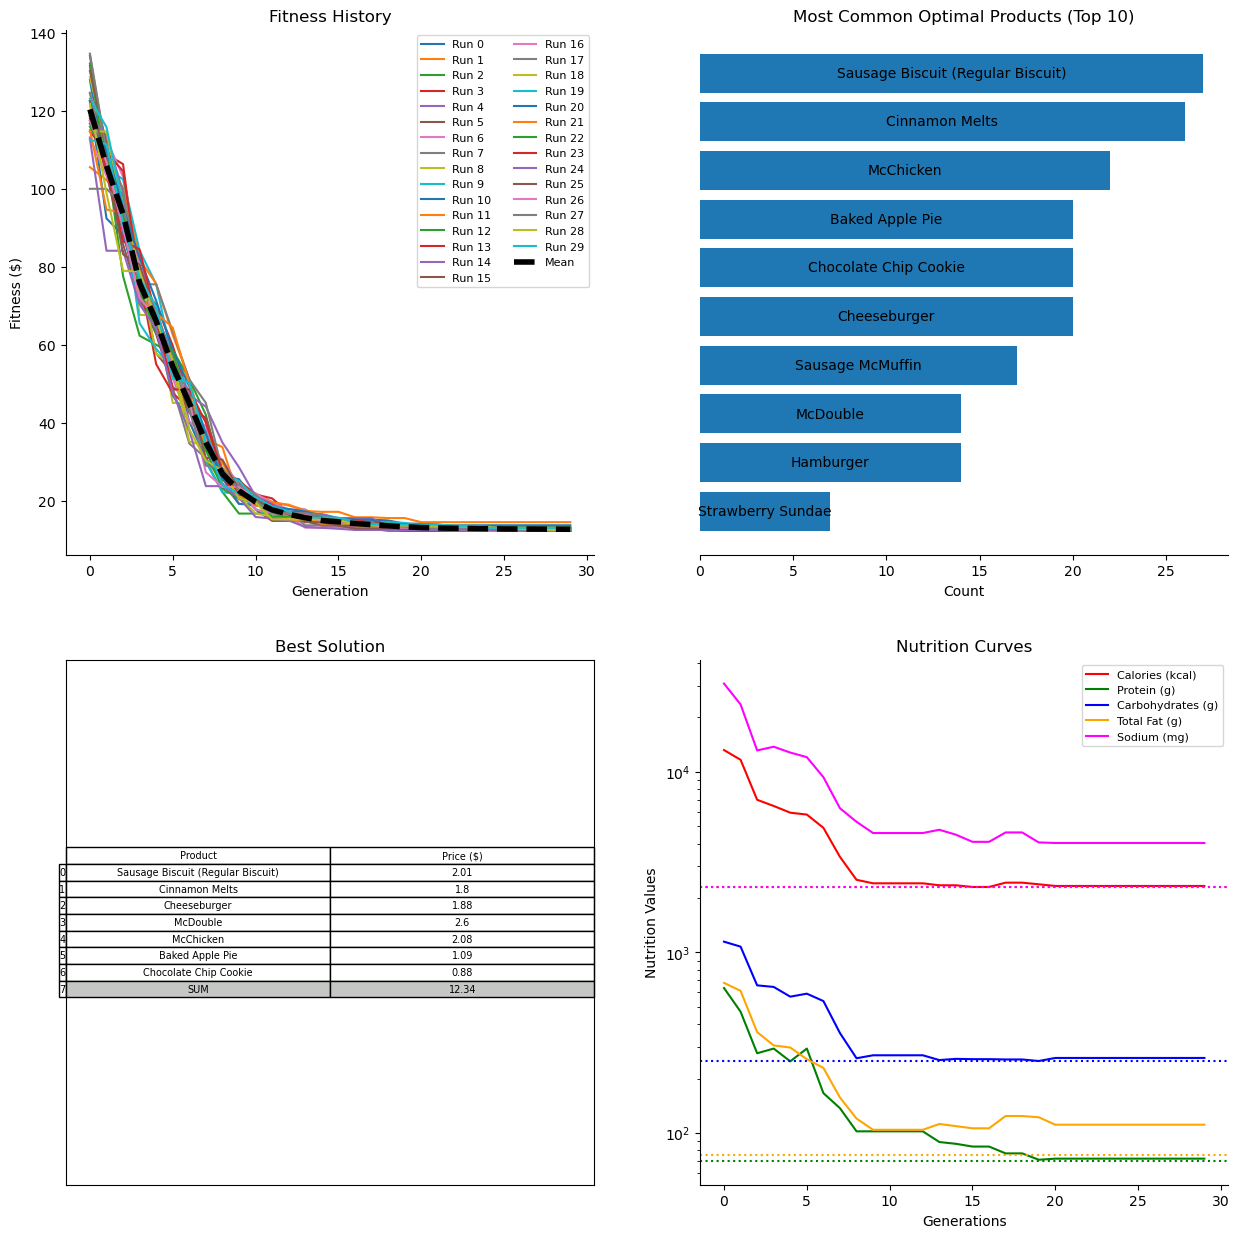

In [16]:
plot_results(results, product_count, table, nutri)

**Conclusion**

|Metric      |Score        |
|------------|-----        |
|Avg. Fitness|fill in value|
|Std. Fitness|fill in value|

---

# 8th Run

|Parameter                 | Value                           |
|--------------------------|---------------------------------|
|Generations per Iterarion:| 100                             |
|Population Size:          | 500                             |
|Selection:                | Tournament                      |
|Mutation:                 | **Single_Swap_Mutation**        |
|Crossover:                | Ten-Point                       |
|Elitism:                  | True                            |

Changing Mutation from **Complete_Bit_Flip** to **Single_Swap_Mutation**

In [17]:
evolve_parameters = {
    "select": tournament,
    "tournament_k": 5,
    "gens": 30,
    "mut_prob": 0.2,
    "mutate": mutation,
    "mut_type": "single_swap_mutation",
    "mut_cycles": None,
    "bit_flips": None,
    "xo_prob": 0.9,
    "crossover": crossover,
    "xo_type": "ten-point",
    "elitism": True
    }

results, product_count, table, nutri = evaluation(population_size=500, evolve_parameters=evolve_parameters)

Average - Fitness: 12.536 USD$
Standard Deviation - Fitness: 0.2574 USD$


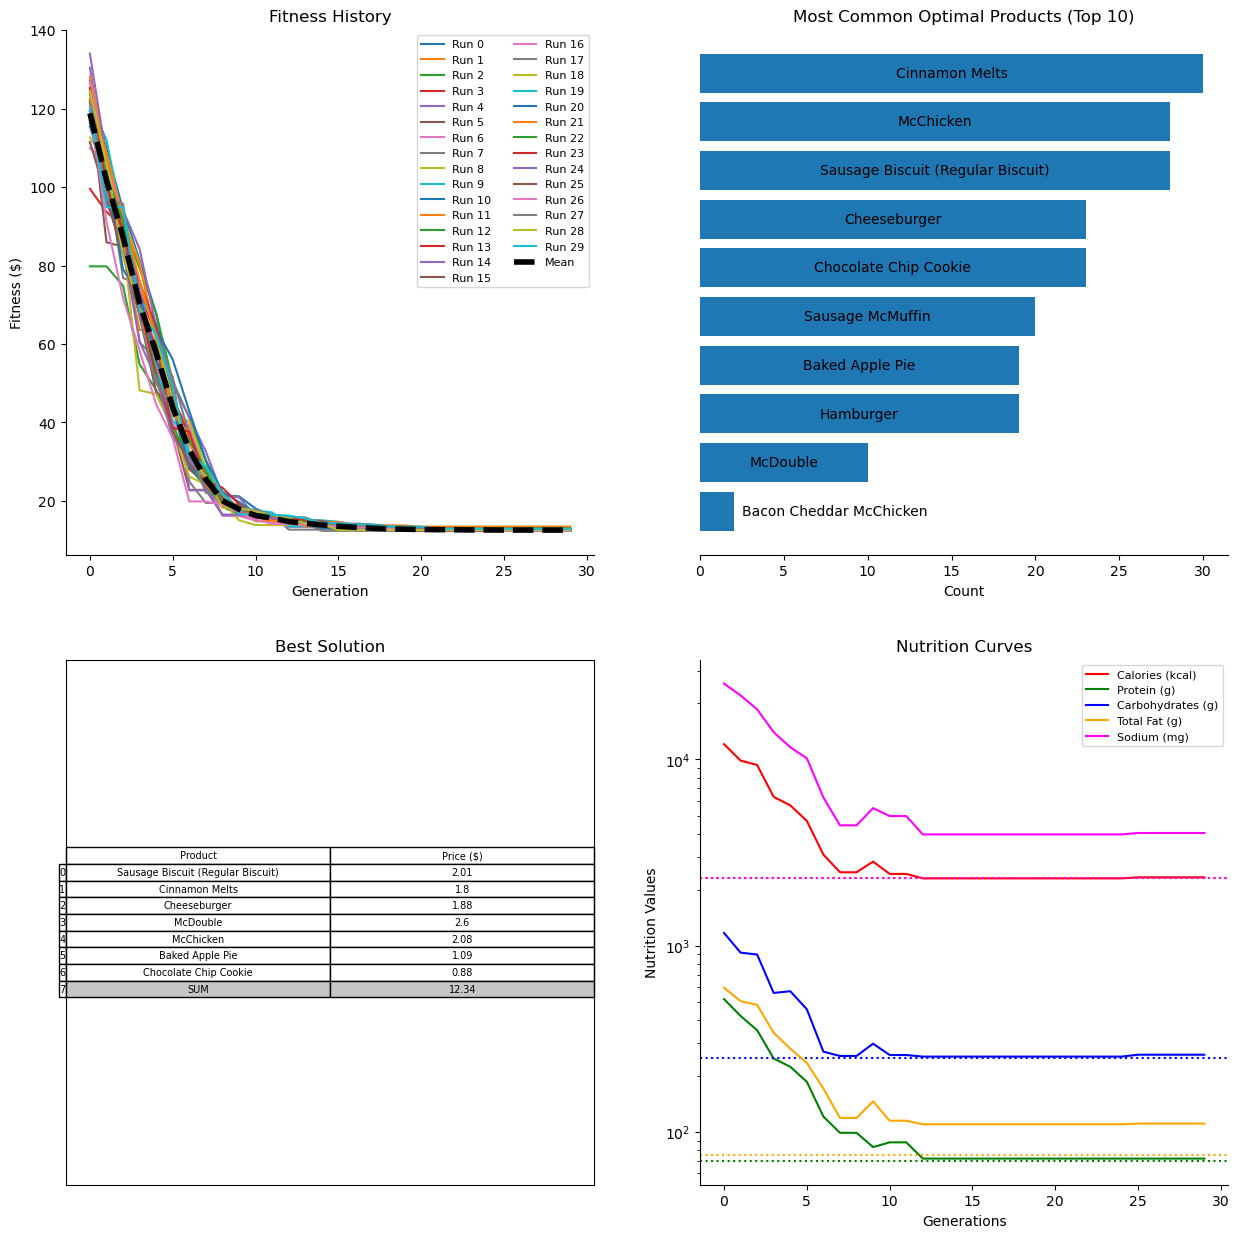

In [18]:
plot_results(results, product_count, table, nutri)

**Conclusion**

|Metric      |Score        |
|------------|-----        |
|Avg. Fitness|fill in value|
|Std. Fitness|fill in value|

---

# 9th Run

|Parameter                 | Value                           |
|--------------------------|---------------------------------|
|Generations per Iterarion:| 100                             |
|Population Size:          | 500                             |
|Selection:                | Tournament                      |
|Mutation:                 | **Multiple_Bit_Flip_Mutation**  |
|Crossover:                | Ten-Point                       |
|Elitism:                  | True                            |

Changing Mutation from **Single_Swap_Mutation** to **Multiple_Bit_Flip_Mutation**

In [21]:
evolve_parameters = {
    "select": tournament,
    "tournament_k": 5,
    "gens": 30,
    "mut_prob": 0.2,
    "mutate": mutation,
    "mut_type": "multiple_bit_flip_mutation",
    "mut_cycles": None,
    "bit_flips": 5,
    "xo_prob": 0.9,
    "crossover": crossover,
    "xo_type": "ten-point",
    "elitism": True
    }

results, product_count, table, nutri = evaluation(population_size=500, evolve_parameters=evolve_parameters)

TypeError: 'NoneType' object cannot be interpreted as an integer

In [ ]:
plot_results(results, product_count, table, nutri)

**Conclusion**

|Metric      |Score        |
|------------|-----        |
|Avg. Fitness|fill in value|
|Std. Fitness|fill in value|

---

# 10th Run

|Parameter                 | Value                           |
|--------------------------|---------------------------------|
|Generations per Iterarion:| 100                             |
|Population Size:          | 500                             |
|Selection:                | Tournament                      |
|Mutation:                 | **Scramble_Mutation**           |
|Crossover:                | Ten-Point                       |
|Elitism:                  | True                            |

Changing Mutation from **Multiple_Bit_Flip_Mutation** to **Scramble_Mutation**

In [ ]:
evolve_parameters = {
    "select": tournament,
    "tournament_k": 5,
    "gens": 30,
    "mut_prob": 0.2,
    "mutate": mutation,
    "mut_type": "scramble_mutation",
    "mut_cycles": None,
    "bit_flips": None,
    "xo_prob": 0.9,
    "crossover": crossover,
    "xo_type": "ten-point",
    "elitism": True
    }

results, product_count, table, nutri = evaluation(population_size=500, evolve_parameters=evolve_parameters)

In [ ]:
plot_results(results, product_count, table, nutri)

**Conclusion**

|Metric      |Score        |
|------------|-----        |
|Avg. Fitness|fill in value|
|Std. Fitness|fill in value|

---

# Final Run

|Parameter                 | Value                           |
|--------------------------|---------------------------------|
|Generations per Iterarion:| *insert value*                  |
|Population Size:          | *insert value*                  |
|Selection:                | *insert value*                  |
|Mutation:                 | *insert value*                  |
|Crossover:                | *insert value*                  |
|Elitism:                  | *insert value*                  |

In [ ]:
evolve_parameters = {
    "select": tournament,
    "tournament_k": 5,
    "gens": 30,
    "mut_prob": 0.2,
    "mutate": mutation,
    "mut_type": "single_swap_mutation",
    "mut_cycles": None,
    "bit_flips": None,
    "xo_prob": 0.9,
    "crossover": crossover,
    "xo_type": "ten-point",
    "elitism": True
    }

results, product_count, table, nutri = evaluation(population_size=100, evolve_parameters=evolve_parameters)

In [ ]:
plot_results(results, product_count, table, nutri)

**Conclusion**

|Metric      |Score        |
|------------|-----        |
|Avg. Fitness|fill in value|
|Std. Fitness|fill in value|

---